In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.grid_search as gs
import sklearn.cross_validation as cv
import sklearn.ensemble as ens
import sklearn.metrics as mts
%matplotlib inline

In [5]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(0, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

scorer = mts.make_scorer(Gini)

In [12]:
train = pd.read_csv('./train.csv', sep = ',', index_col = 'Id')
train_ind = train.index

test = pd.read_csv('./test.csv', sep = ',',index_col = 'Id')
test_ind = test.index

full = pd.concat(objs = [train, test])
full.drop(['T1_V10', 'T1_V13','T2_V7', 'T2_V10'], axis=1, inplace = 1)

In [15]:
full.columns, len(full.columns)

(Index(['Hazard', 'T1_V1', 'T1_V11', 'T1_V12', 'T1_V14', 'T1_V15', 'T1_V16',
        'T1_V17', 'T1_V2', 'T1_V3', 'T1_V4', 'T1_V5', 'T1_V6', 'T1_V7', 'T1_V8',
        'T1_V9', 'T2_V1', 'T2_V11', 'T2_V12', 'T2_V13', 'T2_V14', 'T2_V15',
        'T2_V2', 'T2_V3', 'T2_V4', 'T2_V5', 'T2_V6', 'T2_V8', 'T2_V9'],
       dtype='object'), 29)

In [18]:
full.groupby('T1_V1')['Hazard'].agg('mean')

T1_V1
1     3.267954
2     3.274858
3     3.962464
4     4.143391
5     3.882642
6     3.652564
7     3.862663
8     4.161010
9     4.381741
10    5.529346
11    4.130397
12    3.611129
13    3.451284
14    3.427475
15    3.916905
16    4.538949
17    4.004981
18    4.961089
19    4.834016
Name: Hazard, dtype: float64

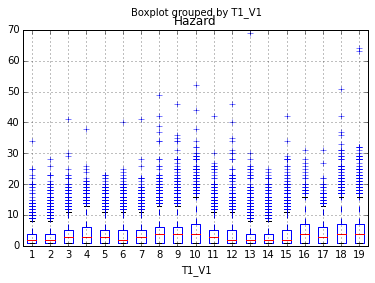

In [21]:
full.boxplot('Hazard', by='T1_V1');

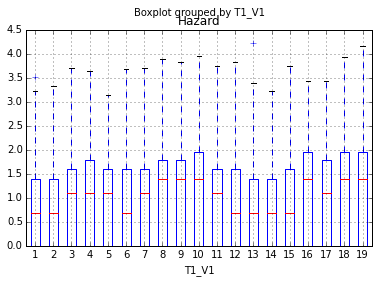

In [23]:
pd.DataFrame({'Hazard': np.log(full.Hazard), 'T1_V1': full.T1_V1}).boxplot('Hazard', 'T1_V1');

## Train 1

In [24]:
full['Hazard'] = np.log(full.Hazard.values)

In [30]:
ntrees = 1000
seed = 1
params_rf = {'max_features': [38,40,42],
             'min_samples_leaf': [8,9,10]}

num_mask = np.array([True if obj != 'object' else False for obj in full.dtypes])
full_num = full.iloc[:,num_mask]
full_cat = full.iloc[:, ~num_mask]
cat_names = full_cat.columns
form = ' + '.join(cat_names)
form += ' - 1'
x_dummies = patsy.dmatrix(form, full_cat, return_type='dataframe')
full_dummies = pd.concat([full_num, x_dummies], axis = 1)
train.shape, full_num.shape, full_cat.shape, x_dummies.shape, full_dummies.shape
split = np.isnan(full_dummies.Hazard)
train = full_dummies.loc[~split,:]
test  = full_dummies.loc[split ,:]
x = train.drop('Hazard', axis=1).values
y = train.Hazard.values

mod_rf2 = ens.RandomForestRegressor(n_estimators = ntrees, random_state = seed, n_jobs = -1)
grid_rf2 = gs.GridSearchCV(mod_rf2, param_grid=params_rf, n_jobs=-1, scoring = scorer, cv=5)

grid_rf2.fit(x,y)

grid_rf2.best_score_

0.32204930791651881

In [31]:
grid_rf2.best_params_

{'max_features': 38, 'min_samples_leaf': 10}